<a href="https://colab.research.google.com/github/zhuofachen/Raman_deep_learning/blob/main/CNN_Spectrum_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import random
import collections
from copy import deepcopy
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
hps = {
    'bs': 16,
    'epochs': 200,
    'lr': 0.005,
    'seed': 42,
    'augment': True
}
# np.random.seed(hps['seed'])
# random.seed(hps['seed'])
# os.environ['PYTHONHASHSEED'] = str(hps['seed'])
# torch.backends.cudnn.benchmark = False
# torch.backends.cudnn.deterministic = True
# torch.manual_seed(hps['seed'])
# torch.cuda.manual_seed(hps['seed'])
# torch.cuda.manual_seed_all(hps['seed'])

# Dataset

In [ ]:
def load_file(filename):
    file = open(filename) 

    lines = file.readlines()
        
    data = []
    for line in lines:
        arr = []
        for num in line.split(","):
            arr.append(float(num))
        data.append(arr)

    return np.array(data)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, spectra, labels, augmentation=None):
        self.spectra = spectra
        self.labels = labels
        self.augmentation = augmentation

    def __len__(self):
        return len(self.spectra)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        spec = self.spectra[idx].reshape(1, -1)
        max_Intensity = np.max(spec, axis = 1)
        if self.augmentation:
            if random.uniform(0, 1) > 0.5: # noise
                noise = np.random.normal(0, max_Intensity/60, spec.shape[1]).astype(np.float32)
                spec = spec + noise
            
            if random.uniform(0, 1) > 0.5: # dropout
                indices = np.random.choice(np.arange(spec.size), replace=False, size=int(spec.size * 0.2))
                spec[:, indices] = 0
            
            if random.uniform(0, 1) > 0.5:   # Shift
                temp = np.zeros(spec.shape).astype(np.float32)
                shift_count = np.random.randint(1, 30)
            
                if random.uniform(0, 1) > 0.5:   # Shift right
                    temp[:, shift_count:] = spec[:, :-shift_count]
                else:
                    temp[:, :-shift_count] = spec[:, shift_count:]
                
                spec = temp

        label = torch.tensor(self.labels[idx]).type(torch.long)
        spec = spec.astype(np.float32)
        sample = (spec/max_Intensity, label)

        return sample

In [ ]:
# Load data
Y = []
data = []
# path = 'datasets/dielectric_dataset/'
# for i in range(4):
#     curr_data = load_file(path + "dielectric" + str(i) + ".txt")    
#     data.append(curr_data)
#     count = len(curr_data)
#     Y.extend([i] * count)

path = 'datasets/charge_dataset/'
for i in range(4):
    curr_data = load_file(path + "c" + str(i) + ".txt")    
    data.append(curr_data)
    count = len(curr_data)
    Y.extend([i] * count)

X = np.vstack(data)
Y = np.array(Y)

print(len(data))
print(len(X))
count = collections.defaultdict(int)
for num in Y:
    count[num] += 1

classes_count = len(count.keys())

for i in sorted(count.keys()):
    print("Class", i, "Count:", count[i])

4
4419
Class 0 Count: 1355
Class 1 Count: 1386
Class 2 Count: 727
Class 3 Count: 951


In [ ]:
# Split data into train, val, & test sets
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, stratify=Y, train_size=0.8, random_state=hps['seed'], shuffle=True)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, stratify=ytrain, train_size=0.8, random_state=hps['seed'], shuffle=True)

print("X shape:\t", X.shape)
print("xtrain shape:\t", xtrain.shape)
print("xval shape:\t", xval.shape)
print("xtest shape:\t", xtest.shape, '\n')

print("Y shape:\t", Y.shape)
print("ytrain shape:\t", ytrain.shape)
print("yval shape:\t", yval.shape)
print("ytest shape:\t", ytest.shape)

X shape:	 (4419, 728)
xtrain shape:	 (2828, 728)
xval shape:	 (707, 728)
xtest shape:	 (884, 728) 

Y shape:	 (4419,)
ytrain shape:	 (2828,)
yval shape:	 (707,)
ytest shape:	 (884,)


# Deep learning Models

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 2, 9, 1)  
        self.conv2 = nn.Conv1d(2, 2, 7, 1)  
        self.conv3 = nn.Conv1d(2, 4, 7, 1)  
        self.conv4 = nn.Conv1d(4, 8, 5, 1)
        self.conv5 = nn.Conv1d(8, 12, 3, 1)

        self.bn1 = nn.BatchNorm1d(2)
        self.bn2 = nn.BatchNorm1d(2)
        self.bn3 = nn.BatchNorm1d(4)
        self.bn4 = nn.BatchNorm1d(8)
        self.bn5 = nn.BatchNorm1d(12)

        self.fc1 = nn.Linear(12 * 19, 128)
        
        self.fc2 = nn.Linear(128, classes_count)   
        self.pool = nn.AvgPool1d(2)

        self.bn6 = nn.BatchNorm1d(128)

        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))       
        x = x.view(-1, 12 * 19)       
        x = self.bn6(F.relu(self.fc1(x)))        
        x = F.relu(self.fc2(x))
        x = self.softmax(x)         
        return x

    def embed(self, x):
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = x.view(-1, 12 * 19)
        x = F.relu(self.fc1(x))
        return x

class FullCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 2, 9, 1)  
        self.conv2 = nn.Conv1d(2, 2, 7, 1)  
        self.conv3 = nn.Conv1d(2, 4, 7, 1)  
        self.conv4 = nn.Conv1d(4, 8, 5, 1)
        self.conv5 = nn.Conv1d(8, 12, 3, 1)

        self.conv6 = nn.Conv1d(12, classes_count, 1, 1)
        self.gap = nn.AvgPool2d((1, 19))

        self.bn1 = nn.BatchNorm1d(2)
        self.bn2 = nn.BatchNorm1d(2)
        self.bn3 = nn.BatchNorm1d(4)
        self.bn4 = nn.BatchNorm1d(8)
        self.bn5 = nn.BatchNorm1d(12)
        self.bn6 = nn.BatchNorm1d(classes_count)

        self.fc1 = nn.Linear(12 * 19, classes_count)           
        self.pool = nn.AvgPool1d(2)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        
        x = self.pool(self.bn1(F.relu(self.conv1(x))))
        x = self.pool(self.bn2(F.relu(self.conv2(x))))
        x = self.pool(self.bn3(F.relu(self.conv3(x))))
        x = self.pool(self.bn4(F.relu(self.conv4(x))))
        x = self.pool(self.bn5(F.relu(self.conv5(x))))
        x = self.bn6(F.relu(self.conv6(x)))

        x = self.gap(x)        
        x = x.view(-1, classes_count)
        x = self.softmax(x)         
        return x


class MultiHead(nn.Module):
    
    def __init__(self):
        super().__init__()

        self.conv1a = nn.Conv1d(1, 16, 3, 1)  
        self.conv2a = nn.Conv1d(1, 16, 5, 1)  
        self.conv3a = nn.Conv1d(1, 16, 7, 1)

        self.conv1b = nn.Conv1d(16, 4, 3, 1)  
        self.conv2b = nn.Conv1d(16, 4, 5, 1)  
        self.conv3b = nn.Conv1d(16, 4, 7, 1)

        self.bn1a = nn.BatchNorm1d(16)
        self.bn2a = nn.BatchNorm1d(16)
        self.bn3a = nn.BatchNorm1d(16)

        self.bn1b = nn.BatchNorm1d(4)
        self.bn2b = nn.BatchNorm1d(4)
        self.bn3b = nn.BatchNorm1d(4)

        self.drop = nn.Dropout(0.01)
        self.pool = nn.MaxPool1d(2)

        self.fc1 = nn.Linear(2144, classes_count)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):

        x1 = self.pool(self.drop(self.bn1a(F.relu(self.conv1a(x)))))
        x2 = self.pool(self.drop(self.bn2a(F.relu(self.conv2a(x)))))
        x3 = self.pool(self.drop(self.bn3a(F.relu(self.conv3a(x)))))

        x1 = self.pool(self.drop(self.bn1b(F.relu(self.conv1b(x1)))))
        x2 = self.pool(self.drop(self.bn2b(F.relu(self.conv2b(x2)))))
        x3 = self.pool(self.drop(self.bn3b(F.relu(self.conv3b(x3)))))

        x1 = x1.view(-1, 4 * 180)
        x2 = x2.view(-1, 4 * 179)
        x3 = x3.view(-1, 4 * 177)
    
        x = torch.cat((x1, x2, x3), dim=1)
        x = F.relu(self.fc1(x))       
        x = self.softmax(x.view(-1, classes_count))

        return x


class Dense(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(728, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 16)
        self.fc7 = nn.Linear(16, classes_count)

        self.bn1 = nn.BatchNorm1d(num_features=1)
        self.bn2 = nn.BatchNorm1d(num_features=1)
        self.bn3 = nn.BatchNorm1d(num_features=1)
        self.bn4 = nn.BatchNorm1d(num_features=1)
        self.bn5 = nn.BatchNorm1d(num_features=1)
        self.bn6 = nn.BatchNorm1d(num_features=1)
 
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        
        x = self.bn1(F.relu(self.fc1(x)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
        x = self.bn4(F.relu(self.fc4(x)))
        x = self.bn5(F.relu(self.fc5(x)))
        x = self.bn6(F.relu(self.fc6(x)))
        x = F.relu(self.fc7(x))
        x = self.softmax(x.view(-1, classes_count))

        return x

# Training and evaluation

In [ ]:
def train(net, dataloader, criterion, optimizer):
    net = net.train()   
    loss_tr, correct_count, n_samples = 0.0, 0.0, 0.0
    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.float().to(device), labels.to(device)
        if len(labels) < 64:
          break

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # calculate performance metrics
        loss_tr += loss.item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_samples += labels.size(0)

    acc = 100 * correct_count / n_samples
    loss = loss_tr / n_samples

    return acc, loss

In [ ]:
def evaluate(net, dataloader, criterion):
    with torch.no_grad():  # remove gradient calculation, by default, in evaluation mode, torch will still calculate gradient. 
        net = net.eval()
        loss_tr, correct_count, n_samples, preds = 0.0, 0.0, 0.0, []
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.float().to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            # calculate performance metrics
            loss_tr += loss.item()

            _, pred = torch.max(outputs.data, 1)
            preds.extend([p.item() for p in pred])
            correct_count += (pred == labels).sum().item()
            n_samples += labels.size(0)

        acc = 100 * correct_count / n_samples
        loss = loss_tr / n_samples

    return acc, loss, preds

# Hyper parameters

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

cnn_hps = {
    'net': CNN,
    'bs': 64,
    'epochs': 100,
    'lr': 0.001,
    'augment': True,    
}

dense_hps = {
    'net': Dense,
    'bs': 64,
    'epochs': 100,
    'lr': 0.001,
    'augment': True, 
}

fullcnn_hps = {
    'net': FullCNN,
    'bs': 16,
    'epochs': 100,
    'lr': 0.001,
    'augment': True,  
}

multihead_hps = {
    'net': MultiHead,
    'bs': 128,
    'epochs': 100,
    'lr': 0.001,
    'augment': True,
}


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().float().to(device)
hps = cnn_hps
hps['seed'] = 42

xtrain, xtest, ytrain, ytest = train_test_split(X, Y, stratify=Y, train_size=0.8, random_state=hps['seed'], shuffle=True)
xtrain, xval, ytrain, yval = train_test_split(xtrain, ytrain, stratify=ytrain, train_size=0.8, random_state=hps['seed'], shuffle=True)
data_train = CustomDataset(xtrain, ytrain, augmentation=hps['augment'])
data_val = CustomDataset(xval, yval)
data_test = CustomDataset(xtest, ytest)
trainloader = DataLoader(data_train, batch_size=hps['bs'], shuffle=True, num_workers=2)
valloader = DataLoader(data_val, batch_size=hps['bs'], shuffle=True, num_workers=2)
testloader = DataLoader(data_test, batch_size=hps['bs'], shuffle=False, num_workers=2)


In [ ]:
# Setup 
optimizer = torch.optim.Adam(model.parameters(), lr=hps['lr'])
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
# Logger
train_accuracy = []
val_accuracy = []

train_loss = []
val_loss = []

best_accuracy = 0

print("Device:", device)
print("Number of Parameters:", count_parameters(model), '\n')

for epoch in range(hps['epochs']):
    # pass through train and val dataloaders
    acc_tr, loss_tr = train(model, trainloader, criterion, optimizer)
    acc_v, loss_v, _ = evaluate(model, valloader, criterion)

    # log metircs
    train_accuracy.append(acc_tr)
    train_loss.append(loss_tr)
    scheduler.step()    
    val_accuracy.append(acc_v)
    val_loss.append(loss_v)
    
    if acc_v > best_accuracy:
        best_accuracy = acc_v
        torch.save(model.state_dict(), "best_params")

    # print
    if (epoch + 1) % 5 == 0:
        print('Epoch %2d' % (epoch + 1),
            'Train Acc: %2.2f %%' % acc_tr,
            'Train Loss: %2.4f' % loss_tr,
            'Val Acc: %2.2f %%' % acc_v,
            'Val Loss: %2.4f' % loss_v,
            sep='\t\t')

Device: cuda:0
Number of Parameters: 12296 

Epoch  5		Train Acc: 84.55 %		Train Loss: 0.0142		Val Acc: 87.98 %		Val Loss: 0.0144
Epoch 10		Train Acc: 86.83 %		Train Loss: 0.0137		Val Acc: 96.04 %		Val Loss: 0.0132
Epoch 15		Train Acc: 88.35 %		Train Loss: 0.0135		Val Acc: 95.62 %		Val Loss: 0.0135
Epoch 20		Train Acc: 89.10 %		Train Loss: 0.0133		Val Acc: 95.76 %		Val Loss: 0.0133
Epoch 25		Train Acc: 88.88 %		Train Loss: 0.0133		Val Acc: 85.43 %		Val Loss: 0.0154
Epoch 30		Train Acc: 88.39 %		Train Loss: 0.0134		Val Acc: 96.04 %		Val Loss: 0.0133
Epoch 35		Train Acc: 90.13 %		Train Loss: 0.0131		Val Acc: 96.32 %		Val Loss: 0.0132
Epoch 40		Train Acc: 90.66 %		Train Loss: 0.0131		Val Acc: 95.76 %		Val Loss: 0.0132
Epoch 45		Train Acc: 90.02 %		Train Loss: 0.0131		Val Acc: 96.75 %		Val Loss: 0.0131
Epoch 50		Train Acc: 91.02 %		Train Loss: 0.0130		Val Acc: 95.90 %		Val Loss: 0.0132
Epoch 55		Train Acc: 91.69 %		Train Loss: 0.0129		Val Acc: 96.46 %		Val Loss: 0.0132
Epoch 60		Train Acc:

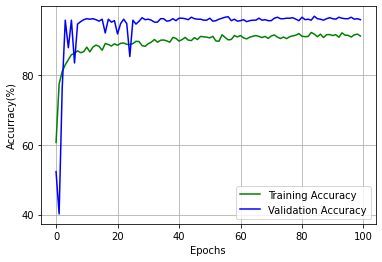

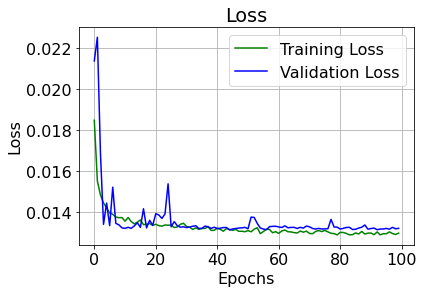

In [ ]:
plt.figure()
plt.plot(train_accuracy, 'g', label='Training Accuracy')
plt.plot(val_accuracy, 'b', label='Validation Accuracy')
# plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accurracy(%)')
plt.legend()
plt.grid()
plt.rcParams['font.size'] = '16'

plt.figure()
plt.plot(train_loss, 'g', label='Training Loss')
plt.plot(val_loss, 'b', label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.rcParams['font.size'] = '16'

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

all_data = CustomDataset(X, Y, augmentation=False)
dataloader = DataLoader(all_data, batch_size=hps['bs'], shuffle=False, num_workers=2)

# get the raw data store in a dictoinary corresponding to each class. rawdata[class] = spec
rawdata = collections.defaultdict(list)
for i in range(4):
  class_spectra = data[i]
  for spec in class_spectra:
    rawdata[i].append(spec)

# get the embedding of each spectrum in each class
embeddings = collections.defaultdict(list)
for batch in dataloader:
  inputs, labels = batch
  inputs, labels = inputs.float().to(device), labels.to(device)
  embedding = model.embed(inputs)
  for label, emb in zip(labels, embedding):
    embeddings[label.item()].append([num.item() for num in emb.view(-1)])




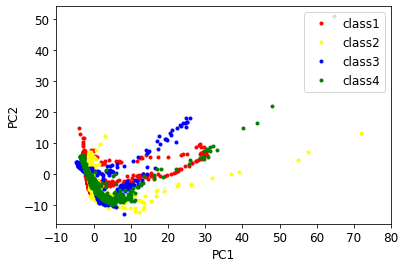

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#standarize the data to be mean at 0 and variance of 1. 
pca_data = collections.defaultdict(list)
pca_embedding = collections.defaultdict(list)
pca = PCA(n_components=3)
for i in range(4):
    specs = rawdata[i]
    embeds = embeddings[i]    
    
    specs_standard = StandardScaler().fit_transform(specs)
    embeds_standard = StandardScaler().fit_transform(embeds)
    spec_pca = pca.fit_transform(specs_standard)
    embeds_pca = pca.fit_transform(embeds_standard)

    pca_data[i] = spec_pca
    pca_embedding[i] = embeds_pca

def plot3D(pca_data):
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  color = ['red', 'yellow', 'blue', 'green']
  markers = ['o', '+', '*', 'v']
  for i in range(4):
      ax.scatter(pca_data[i][:,0], pca_data[i][:,1],pca_data[i][:,2], c=color[i], marker=markers[i], label = 'Class' + str(i + 1))
  plt.legend(loc="upper left")
  plt.xlim([-50, 50])
  ax.set_xlabel('PC1')
  ax.set_ylabel('PC2')
  ax.set_zlabel('PC3')
  plt.show()
  plt.rcParams['font.size'] = '12'
  return fig

def plot2D(pca_data):
  fig = plt.figure()
  color = ['red', 'yellow', 'blue', 'green']
  markers = ['o', '+', '*', 'v']
  for i in range(4):  
      plt.plot(pca_data[i][:,0], pca_data[i][:,1], 'o', markerfacecolor=color[i],
           markeredgecolor=color[i],  markersize=3, label='class' + str(i + 1))
  plt.legend(loc="upper right")
  plt.xlim([-10, 80])
  # plt.xlim([-15, 30])
  # plt.ylim([-20, 30])
  # ax.set_zlim(-20, 30)
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.show()
  plt.rcParams['font.size'] = '12'
  return fig

f1 = plot3D(pca_data)
f1.savefig('PCA_rawdata.jpg')
f2 = plot3D(pca_embedding)
f2.savefig('PCA_embedding.jpg')
